In [1]:
!pip install timm torch torchvision matplotlib scikit-learn


In [1]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset directory
DATASET_DIR = '/content/drive/MyDrive/AIDI_1011_AI Project/Dataset1-8_9Class_2022_09_15'  # Update this to your dataset path in GeorgianCapstone Folder using various

print(f"Dataset directory: {os.listdir(DATASET_DIR)}")


Mounted at /content/drive
Dataset directory: ['.DS_Store', 'train', 'val']


In [3]:
import os
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np


In [4]:
# Define transformations for training and validation datasets
IMG_SIZE = 224
BATCH_SIZE = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(DATASET_DIR, 'train'), transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(DATASET_DIR, 'val'), transform=data_transforms['val'])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Check class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")


Classes: ['bcc', 'bkl', 'mel', 'nv', 'scc', 'vasc']


In [18]:
import torch.nn as nn

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pretrained Swin Transformer model
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=len(class_names))

# Move the model to GPU
model = model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)


Using device: cpu


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

In [19]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_labels, all_preds


In [20]:
EPOCHS = 10

best_acc = 0.0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 20)

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_labels, val_preds = validate_one_epoch(model, val_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_swin_transformer.pth")

print(f"Best Validation Accuracy: {best_acc:.4f}")


Epoch 1/10
--------------------
Train Loss: 1.4202, Train Acc: 0.4198
Val Loss: 1.4199, Val Acc: 0.4767
Epoch 2/10
--------------------
Train Loss: 1.2031, Train Acc: 0.5142
Val Loss: 1.5061, Val Acc: 0.4070
Epoch 3/10
--------------------
Train Loss: 0.9422, Train Acc: 0.6195
Val Loss: 2.1075, Val Acc: 0.3023
Epoch 4/10
--------------------
Train Loss: 0.7448, Train Acc: 0.7280
Val Loss: 2.9515, Val Acc: 0.2093
Epoch 5/10
--------------------
Train Loss: 0.5567, Train Acc: 0.7846
Val Loss: 2.9220, Val Acc: 0.2209
Epoch 6/10
--------------------
Train Loss: 0.5072, Train Acc: 0.8239
Val Loss: 3.1364, Val Acc: 0.3372
Epoch 7/10
--------------------
Train Loss: 0.4558, Train Acc: 0.8381
Val Loss: 4.0643, Val Acc: 0.1628
Epoch 8/10
--------------------
Train Loss: 0.3746, Train Acc: 0.8585
Val Loss: 4.0442, Val Acc: 0.1395
Epoch 9/10
--------------------
Train Loss: 0.2630, Train Acc: 0.9057
Val Loss: 4.3999, Val Acc: 0.1628
Epoch 10/10
--------------------
Train Loss: 0.2193, Train Acc: 

<ipython-input-25-61a509024289>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_swin_transformer.pth"))


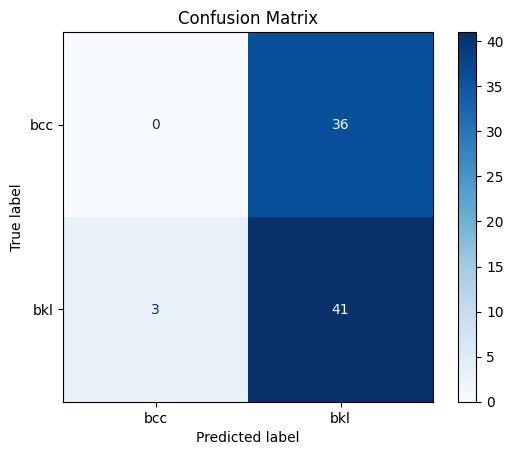

Classification Report:
              precision    recall  f1-score   support

         bcc       0.00      0.00      0.00        37
         bkl       0.53      0.84      0.65        49

   micro avg       0.51      0.48      0.49        86
   macro avg       0.27      0.42      0.33        86
weighted avg       0.30      0.48      0.37        86



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:2687: UserWarning: labels size, 2, does not match size of target_names, 6
  warnings.warn(


In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the best model
model.load_state_dict(torch.load("best_swin_transformer.pth"))
model.eval()

_, _, val_labels, val_preds = validate_one_epoch(model, val_loader, criterion, device)

# Get the unique labels from the validation predictions
unique_labels = np.unique(val_labels)

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds, labels=unique_labels)


# Filter class_names to only include labels present in val_labels
filtered_class_names = [class_names[i] for i in unique_labels]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=filtered_class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=class_names, labels=unique_labels))


In [30]:
from sklearn.preprocessing import label_binarize

# Binarize the labels
val_labels_bin = label_binarize(val_labels, classes=list(range(len(class_names))))
val_preds_prob = torch.softmax(torch.tensor(val_preds), dim=1).cpu().numpy()

# Plot ROC curve
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(val_labels_bin[:, i], val_preds_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)